In [14]:
import torch
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("USING device :",device)
print(torch.cuda.get_device_name(0))

USING device : cuda
NVIDIA A100-SXM4-80GB


# Configuration

In [15]:
import numpy as np
import os
# from sklearn.preprocessing import LabelEncoder
import cv2

In [16]:
data_path = r"../datasets/office31"
num_domains = 3
num_classes = 31
all_domains = ["amazon", "dslr", "webcam"]
all_classes = ["back_pack", "bike", "bike_helmet", "bookcase", "bottle", "calculator", "desk_chair", "desk_lamp", \
               "desktop_computer", "file_cabinet", "headphones", "keyboard", "laptop_computer", "letter_tray", "mobile_phone", \
                "monitor", "mouse", "mug", "paper_notebook", "pen", "phone", "printer", "projector", "punchers", \
                "ring_binder", "ruler", "scissors", "speaker", "stapler", "tape_dispenser", "trash_can"]

train_dom_idx = [0,1]
eval_dom_idx = [2]
train_class_idx = list(range(29))
eval_class_idx = [29,30]
train_domains = all_domains[:2]
eval_domains = all_domains[2:]
train_classes = all_classes[:29]
eval_classes = all_classes[29:]

len(train_classes)

29

# Definitions

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from PIL import Image

In [18]:
# ---------------- Custom Dataset with Data Augmentation ----------------
# Assuming training_images and testing_images are NumPy arrays with shape (N, 128, 128, 3)
# and training_labels and testing_labels are NumPy arrays with integer labels.
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: NumPy array of shape (N, 128, 128, 3)
        labels: NumPy array of shape (N,)
        transform: torchvision transforms to be applied on each image
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Convert the NumPy image (H, W, C) to a PIL Image for transforms
        image = Image.fromarray((image * 255).astype(np.uint8))  # if images are in [0,1]
        if self.transform:
            image = self.transform(image)
        return image, label


In [19]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (32, 128, 128)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # (32, 64, 64)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # (64, 64, 64)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # (64, 32, 32)
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (128, 32, 32)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)          # (128, 16, 16)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        # Flatten the feature maps: alternative to x = x.view(x.size(0), -1)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x


# Training Data Preparation

In [20]:
def image_reader(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    return img

In [21]:
def numpi_shuffler(images, labels):
    images_np = np.array(images)
    encoded_labels_np = np.array(labels)

    # Create a random permutation of indices and shuffle arrays
    indices = np.random.permutation(len(images_np))
    shuffled_images = images_np[indices]
    shuffled_labels = encoded_labels_np[indices]

    return shuffled_images, shuffled_labels

In [22]:
# ---------------- Define Transforms ----------------
# Training transform with data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Rotate by up to 10 degrees
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random crop and resize back to 128x128
    transforms.ToTensor(),
    # If you used normalization during training, add it here.
    # e.g., transforms.Normalize(mean=[...], std=[...])
])

# Testing transform: only resize and convert to tensor
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [23]:
dTrain_images = []
cTrain_images = {dom:[] for dom in train_domains}
dFamiliar_images = []
cFamiliar_images = {dom:[] for dom in train_domains}
dTrain_label = []
cTrain_label = {dom:[] for dom in train_domains}
dFamiliar_label = []
cFamiliar_label = {dom:[] for dom in train_domains}

for d in range(len(train_domains)):
    domain = train_domains[d]
    for c in range(len(train_classes)):
        clas = train_classes[c]
        directory_path = os.path.join(data_path, domain, clas)
        for file_name in os.listdir(directory_path):
            file_path = os.path.join(directory_path, file_name)
            if np.random.uniform(0.0, 1.0) < 0.8:
                dTrain_images.append(image_reader(file_path))
                dTrain_label.append(d)
                cTrain_images[domain].append(image_reader(file_path))
                cTrain_label[domain].append(c)
            else:
                dFamiliar_images.append(image_reader(file_path))
                dFamiliar_label.append(d)
                cFamiliar_images[domain].append(image_reader(file_path))
                cFamiliar_label[domain].append(c)

dLabel_mapping = {i:train_domains[i] for i in range(len(train_domains))}
cLabel_mapping = {i:train_classes[i] for i in range(len(train_classes))}

In [24]:
dTrain_images, dTrain_label = numpi_shuffler(dTrain_images, dTrain_label)
dFamiliar_images, dFamiliar_label = numpi_shuffler(dFamiliar_images, dFamiliar_label)
for dom in train_domains:
    cTrain_images[dom], cTrain_label[dom] = numpi_shuffler(cTrain_images[dom], cTrain_label[dom])
    cFamiliar_images[dom], cFamiliar_label[dom] = numpi_shuffler(cFamiliar_images[dom], cFamiliar_label[dom])

In [ ]:
# Create custom datasets and Dataloaders
dTrain_dataset = CustomDataset(dTrain_images, dTrain_label, transform=train_transform)
dFamiliar_dataset = CustomDataset(dFamiliar_images, dFamiliar_label, transform=test_transform)
dTrain_loader = DataLoader(dTrain_dataset, batch_size=32, shuffle=True)
dFamiliar_loader  = DataLoader(dFamiliar_dataset, batch_size=32, shuffle=False)

cTrain_datasets = {dom:CustomDataset(cTrain_images[dom], cTrain_label[dom], transform=train_transform) for dom in train_domains}
cFamiliar_datasets = {dom:CustomDataset(cFamiliar_images[dom], cFamiliar_label[dom], transform=train_transform) for dom in train_domains}
cTrain_loaders = {dom:DataLoader(cTrain_datasets[dom], batch_size=32, shuffle=True) for dom in train_domains}
cFamiliar_loaders  = {dom:DataLoader(cFamiliar_datasets[dom], batch_size=32, shuffle=False) for dom in train_domains}

domain_model = SimpleCNN(num_classes=len(train_domains)).to(device)
class_models = {dom:SimpleCNN(num_classes=len(train_classes)).to(device) for dom in train_domains}

# Model Training

In [ ]:
num_epochs = 20
def Trainer(num_epochs, learning_rate, weight_d, model, train_loader, train_dataset):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_d)
    # Optionally, add a learning rate scheduler:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images=images.to(device)
            #labels = torch.tensor(labels)
            labels=labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_dataset)
        if (epoch+1)%5==0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        # Update scheduler if using one
        scheduler.step(epoch_loss)

In [28]:
print("Domain Classifier")
Trainer(num_epochs, 0.001, 1e-5, domain_model, dTrain_loader, dTrain_dataset)

Domain Classifier
Epoch [5/20], Loss: 0.0290
Epoch [10/20], Loss: 0.0196
Epoch [15/20], Loss: 0.0221
Epoch [20/20], Loss: 0.0132


In [29]:
for dom in train_domains:
    print(dom+" Classifier")
    Trainer(50, 0.0001, 1e-5, class_models[dom], cTrain_loaders[dom], cTrain_datasets[dom])

amazon Classifier
Epoch [5/50], Loss: 2.8641
Epoch [10/50], Loss: 2.5368
Epoch [15/50], Loss: 2.3365
Epoch [20/50], Loss: 2.1641
Epoch [25/50], Loss: 2.0127
Epoch [30/50], Loss: 1.8688
Epoch [35/50], Loss: 1.7674
Epoch [40/50], Loss: 1.7034
Epoch [45/50], Loss: 1.6188
Epoch [50/50], Loss: 1.5816
dslr Classifier
Epoch [5/50], Loss: 3.2315
Epoch [10/50], Loss: 2.7142
Epoch [15/50], Loss: 2.1612
Epoch [20/50], Loss: 1.7193
Epoch [25/50], Loss: 1.4052
Epoch [30/50], Loss: 1.2572
Epoch [35/50], Loss: 1.0491
Epoch [40/50], Loss: 0.9391
Epoch [45/50], Loss: 0.9205
Epoch [50/50], Loss: 0.8107


# **MODEL EVALUATION**

1. CLASSIFICATION REPORT USING SEG_TEST
2. CONFUSION MATRIX

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch.nn.functional as F

In [31]:
def entropy(cls_prob):
    score = -torch.sum(cls_prob * torch.log(cls_prob.clamp(min=1e-12)), dim=1)
    return score

In [ ]:
def ModelChecker(model, test_loader, class_names):
    model.eval()
    all_preds=[]
    all_labels=[]
    all_certs=[]
    all_uncerts=[]

    with torch.no_grad():
        for images,labels in test_loader:
            images=images.to(device)
            labels= labels.to(device)
            outputs= model(images)
            probs = F.softmax(outputs, dim=1)
            certs,preds = torch.max(probs,1)
            all_certs.extend(certs.cpu().numpy())
            #_,preds=torch.max(outputs,1)
            uncerts = entropy(probs)
            all_uncerts.extend(uncerts.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds=np.array(all_preds)
    all_labels=np.array(all_labels)
    all_certs=np.array(all_certs)
    all_uncerts=np.array(all_uncerts)

    report= classification_report(all_labels,all_preds,target_names=class_names)
    print("classification report:\n",report)

    conf_matrix= confusion_matrix(all_labels,all_preds)
    # print("Confusion Matrix:\n",conf_matrix)

    correct_mask = all_preds == all_labels
    incorrect_mask = ~correct_mask

    # -------------------------------
    # Set up the figure
    # -------------------------------
    fig = plt.figure(figsize=(16, 12))
    grid = GridSpec(3, 2, height_ratios=[1.2, 1, 1])

    ax0 = fig.add_subplot(grid[0, :])
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(ax=ax0, cmap='Blues', values_format='d', colorbar=False)
    ax0.set_title('Confusion Matrix')

    ax1 = fig.add_subplot(grid[1, 0])
    sns.histplot(all_certs[correct_mask], bins=30, kde=True, color='green', ax=ax1)
    ax1.set_title('Certainty — Correct Predictions')
    ax1.set_xlabel('Certainty')
    ax1.set_ylabel('Count')

    ax2 = fig.add_subplot(grid[1, 1])
    sns.histplot(all_certs[incorrect_mask], bins=30, kde=True, color='red', ax=ax2)
    ax2.set_title('Certainty — Incorrect Predictions')
    ax2.set_xlabel('Certainty')
    ax2.set_ylabel('Count')

    ax3 = fig.add_subplot(grid[2, 0])
    sns.histplot(all_uncerts[correct_mask], bins=30, kde=True, color='blue', ax=ax3)
    ax3.set_title('Uncertainty — Correct Predictions')
    ax3.set_xlabel('Uncertainty')
    ax3.set_ylabel('Count')

    ax4 = fig.add_subplot(grid[2, 1])
    sns.histplot(all_uncerts[incorrect_mask], bins=30, kde=True, color='orange', ax=ax4)
    ax4.set_title('Uncertainty — Incorrect Predictions')
    ax4.set_xlabel('Uncertainty')
    ax4.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

classification report:
               precision    recall  f1-score   support

      amazon       0.99      1.00      0.99       525
        dslr       0.99      0.94      0.96       114

    accuracy                           0.99       639
   macro avg       0.99      0.97      0.98       639
weighted avg       0.99      0.99      0.99       639

Confusion Matrix:
 [[524   1]
 [  7 107]]


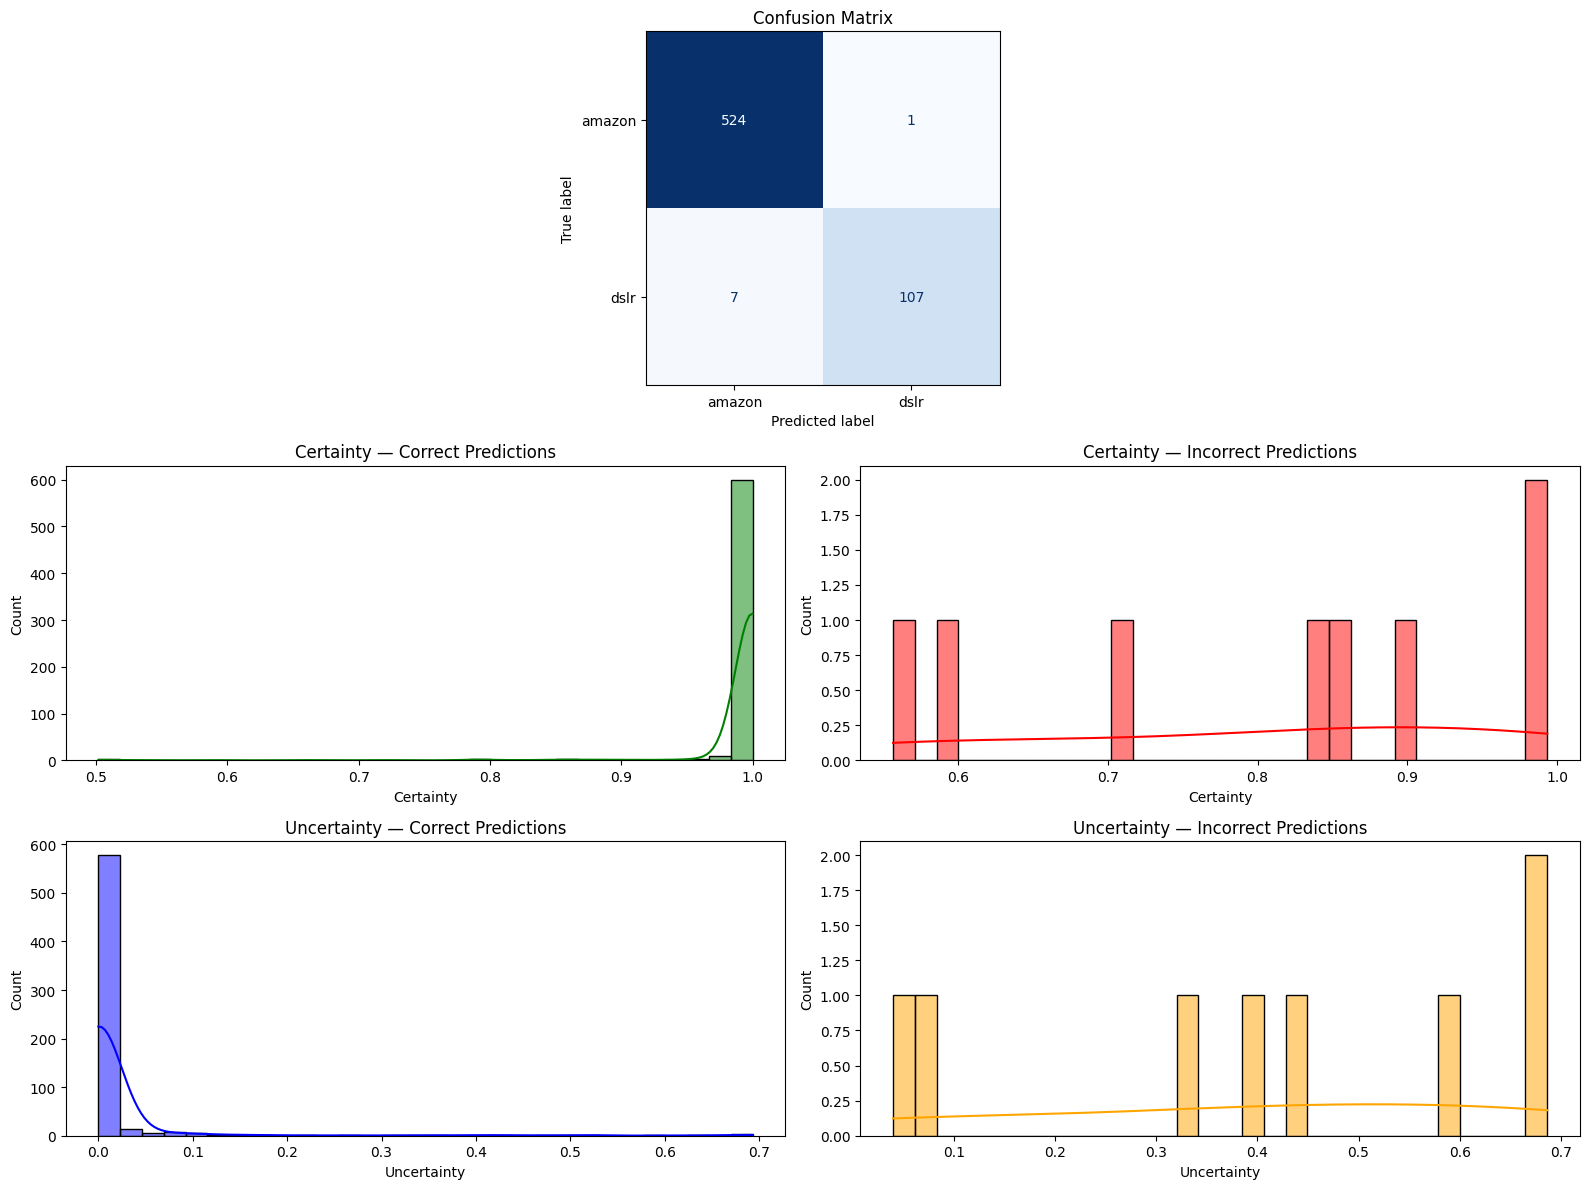

In [33]:
ModelChecker(domain_model, dFamiliar_loader, train_domains)

classification report:
                   precision    recall  f1-score   support

       back_pack       0.57      0.86      0.69        14
            bike       0.95      0.82      0.88        22
     bike_helmet       0.44      0.89      0.59         9
        bookcase       0.92      0.52      0.67        21
          bottle       0.50      0.33      0.40         6
      calculator       0.94      0.62      0.75        24
      desk_chair       0.73      0.92      0.81        12
       desk_lamp       0.55      0.84      0.67        19
desktop_computer       0.79      0.55      0.65        20
    file_cabinet       0.29      0.17      0.22        23
      headphones       0.58      0.69      0.63        16
        keyboard       0.56      0.61      0.58        23
 laptop_computer       0.73      0.89      0.80        18
     letter_tray       0.30      0.38      0.33        16
    mobile_phone       0.61      0.78      0.68        18
         monitor       0.83      0.88      0.86

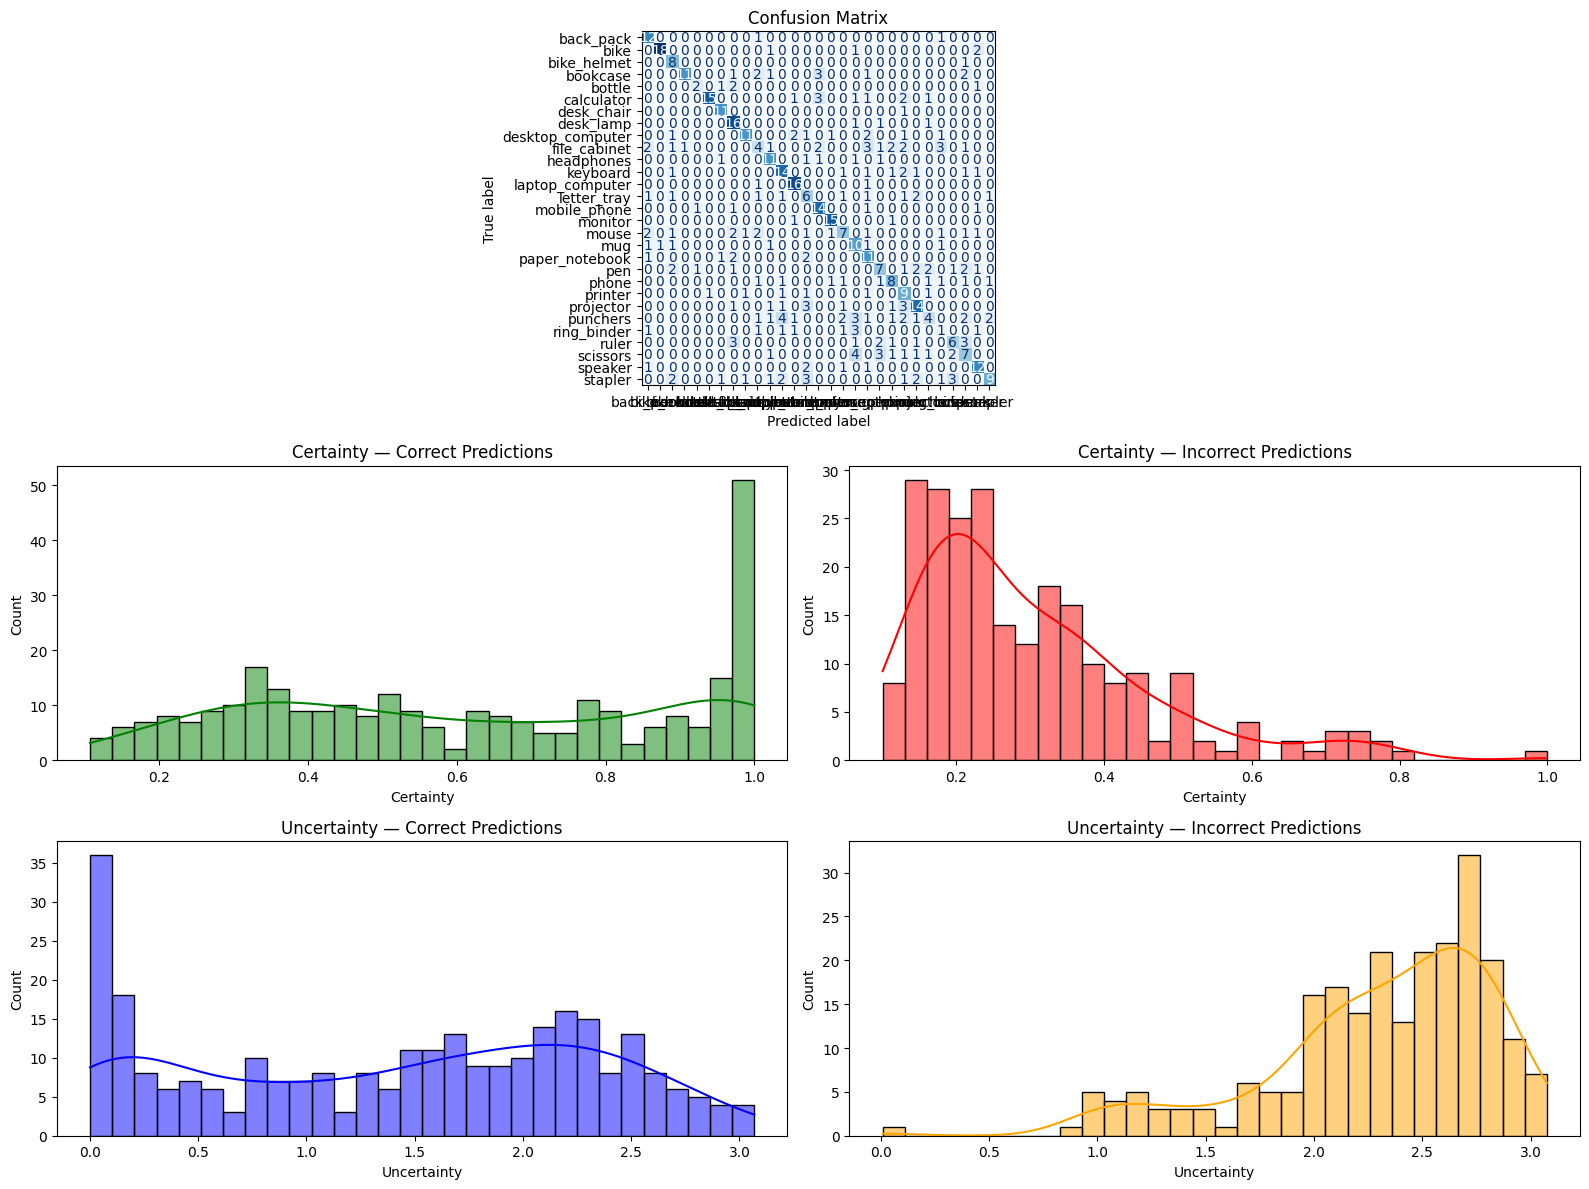

In [34]:
ModelChecker(class_models["amazon"], cFamiliar_loaders["amazon"], train_classes)

/raid/infolab/bhavyakohli/miniconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/raid/infolab/bhavyakohli/miniconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/raid/infolab/bhavyakohli/miniconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

classification report:
                   precision    recall  f1-score   support

       back_pack       0.75      1.00      0.86         3
            bike       0.67      1.00      0.80         4
     bike_helmet       0.62      1.00      0.77         5
        bookcase       0.25      0.50      0.33         2
          bottle       1.00      1.00      1.00         6
      calculator       0.33      1.00      0.50         1
      desk_chair       0.50      1.00      0.67         1
       desk_lamp       1.00      0.67      0.80         3
desktop_computer       1.00      0.60      0.75         5
    file_cabinet       0.60      0.60      0.60         5
      headphones       0.00      0.00      0.00         2
        keyboard       1.00      0.50      0.67         2
 laptop_computer       1.00      1.00      1.00         4
     letter_tray       1.00      0.75      0.86         4
    mobile_phone       0.80      0.40      0.53        10
         monitor       1.00      1.00      1.00

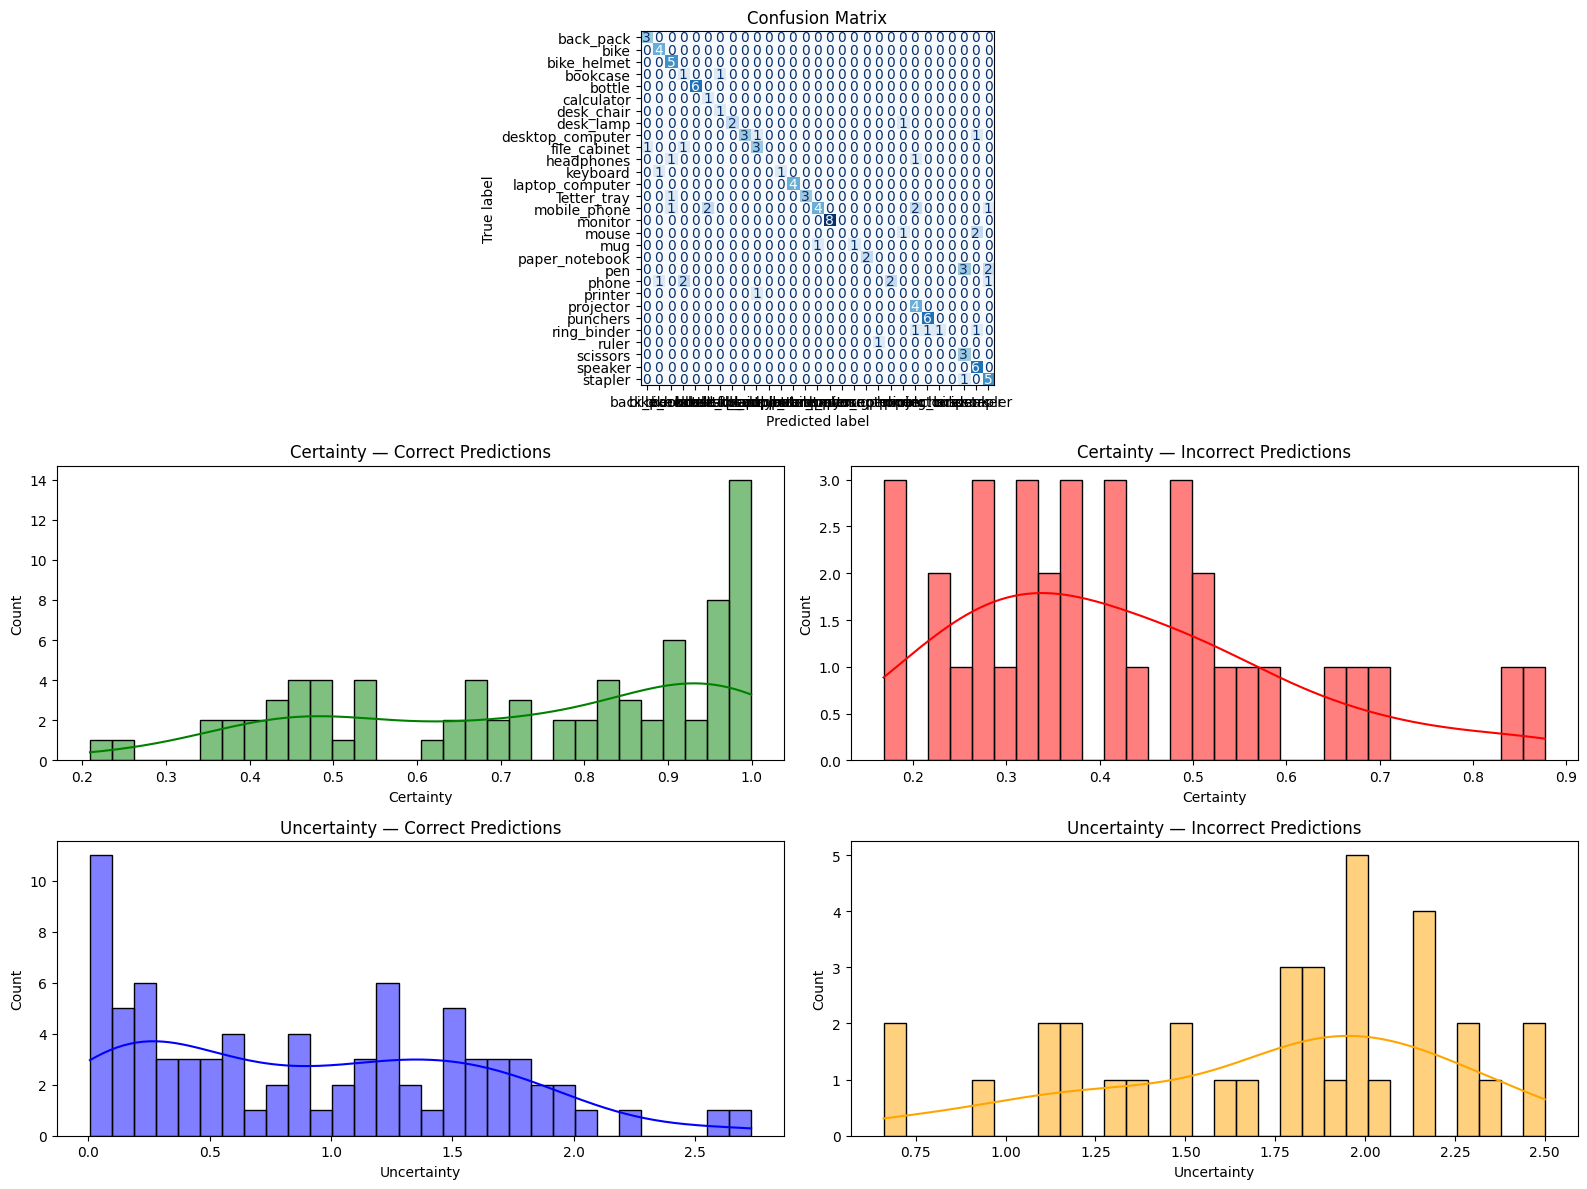

In [35]:
ModelChecker(class_models["dslr"], cFamiliar_loaders["dslr"], train_classes)

In [ ]:
def CompleteChecker(domain_model, class_models, test_loader, train_domain_names, class_names):
    domain_model.eval()
    for dom in train_domain_names:
        class_models[dom].eval()

    all_preds=[]
    all_labels=[]
    all_certs=[]
    all_uncerts=[]

    with torch.no_grad():
        for images,labels in test_loader:
            images=images.to(device)
            labels= labels.to(device)

            dom_outputs= domain_model(images)
            dom_probs = F.softmax(dom_outputs, dim=1)

            class_outputs = {}
            class_probs = {}
            for dom in train_domain_names:
                class_outputs[dom] = class_models[dom](images)
                class_probs[dom] = F.softmax(class_outputs[dom], dim=1)
            
            probs = torch.zeros_like(next(iter(class_probs.values())))
            for idx, dom in enumerate(train_domain_names):
                weight = dom_probs[:, idx].unsqueeze(1)
                probs += weight * class_probs[dom]

            certs,preds = torch.max(probs,1)
            uncerts = entropy(probs)

            all_certs.extend(certs.cpu().numpy())
            all_uncerts.extend(uncerts.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds=np.array(all_preds)
    all_labels=np.array(all_labels)
    all_certs=np.array(all_certs)
    all_uncerts=np.array(all_uncerts)

    report= classification_report(all_labels,all_preds,target_names=class_names)
    print("classification report:\n",report)

    conf_matrix= confusion_matrix(all_labels,all_preds)
    #print("Confusion Matrix:\n",conf_matrix)

    correct_mask = all_preds == all_labels
    incorrect_mask = ~correct_mask

    # -------------------------------
    # Set up the figure
    # -------------------------------
    fig = plt.figure(figsize=(16, 12))
    grid = GridSpec(3, 2, height_ratios=[1.2, 1, 1])

    ax0 = fig.add_subplot(grid[0, :])
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(ax=ax0, cmap='Blues', values_format='d', colorbar=False)
    ax0.set_title('Confusion Matrix')

    ax1 = fig.add_subplot(grid[1, 0])
    sns.histplot(all_certs[correct_mask], bins=30, kde=True, color='green', ax=ax1)
    ax1.set_title('Certainty — Correct Predictions')
    ax1.set_xlabel('Certainty')
    ax1.set_ylabel('Count')

    ax2 = fig.add_subplot(grid[1, 1])
    sns.histplot(all_certs[incorrect_mask], bins=30, kde=True, color='red', ax=ax2)
    ax2.set_title('Certainty — Incorrect Predictions')
    ax2.set_xlabel('Certainty')
    ax2.set_ylabel('Count')

    ax3 = fig.add_subplot(grid[2, 0])
    sns.histplot(all_uncerts[correct_mask], bins=30, kde=True, color='blue', ax=ax3)
    ax3.set_title('Uncertainty — Correct Predictions')
    ax3.set_xlabel('Uncertainty')
    ax3.set_ylabel('Count')

    ax4 = fig.add_subplot(grid[2, 1])
    sns.histplot(all_uncerts[incorrect_mask], bins=30, kde=True, color='orange', ax=ax4)
    ax4.set_title('Uncertainty — Incorrect Predictions')
    ax4.set_xlabel('Uncertainty')
    ax4.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

classification report:
                   precision    recall  f1-score   support

       back_pack       0.55      0.86      0.67        14
            bike       1.00      0.77      0.87        22
     bike_helmet       0.44      0.78      0.56         9
        bookcase       1.00      0.48      0.65        21
          bottle       0.50      0.33      0.40         6
      calculator       0.91      0.83      0.87        24
      desk_chair       0.58      0.92      0.71        12
       desk_lamp       0.53      0.84      0.65        19
desktop_computer       0.75      0.45      0.56        20
    file_cabinet       0.33      0.17      0.23        23
      headphones       0.68      0.81      0.74        16
        keyboard       0.54      0.65      0.59        23
 laptop_computer       0.64      0.78      0.70        18
     letter_tray       0.39      0.44      0.41        16
    mobile_phone       0.89      0.89      0.89        18
         monitor       0.74      0.82      0.78

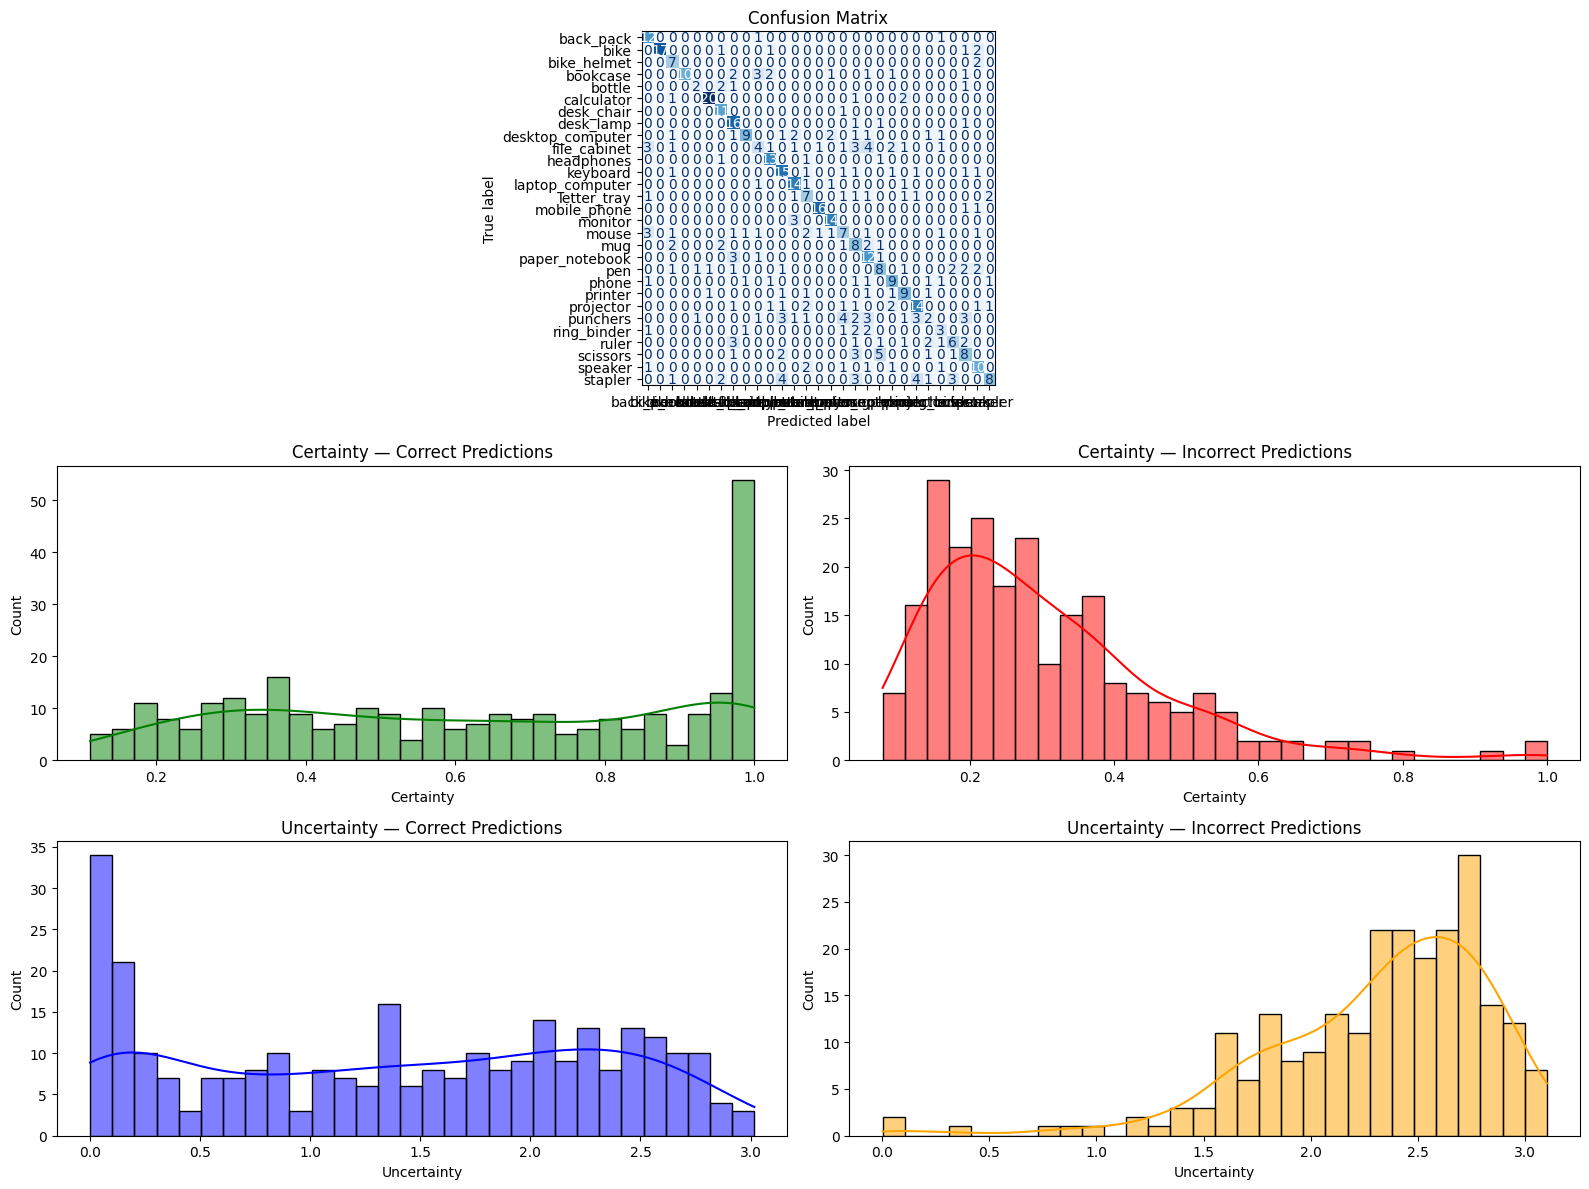

In [37]:
CompleteChecker(domain_model, class_models, cFamiliar_loaders["amazon"], train_domains, train_classes)

/raid/infolab/bhavyakohli/miniconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/raid/infolab/bhavyakohli/miniconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/raid/infolab/bhavyakohli/miniconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

classification report:
                   precision    recall  f1-score   support

       back_pack       0.60      1.00      0.75         3
            bike       0.67      1.00      0.80         4
     bike_helmet       0.71      1.00      0.83         5
        bookcase       0.00      0.00      0.00         2
          bottle       1.00      1.00      1.00         6
      calculator       0.33      1.00      0.50         1
      desk_chair       1.00      1.00      1.00         1
       desk_lamp       1.00      1.00      1.00         3
desktop_computer       1.00      0.40      0.57         5
    file_cabinet       0.60      0.60      0.60         5
      headphones       0.50      0.50      0.50         2
        keyboard       0.00      0.00      0.00         2
 laptop_computer       1.00      1.00      1.00         4
     letter_tray       1.00      0.75      0.86         4
    mobile_phone       0.80      0.40      0.53        10
         monitor       1.00      1.00      1.00

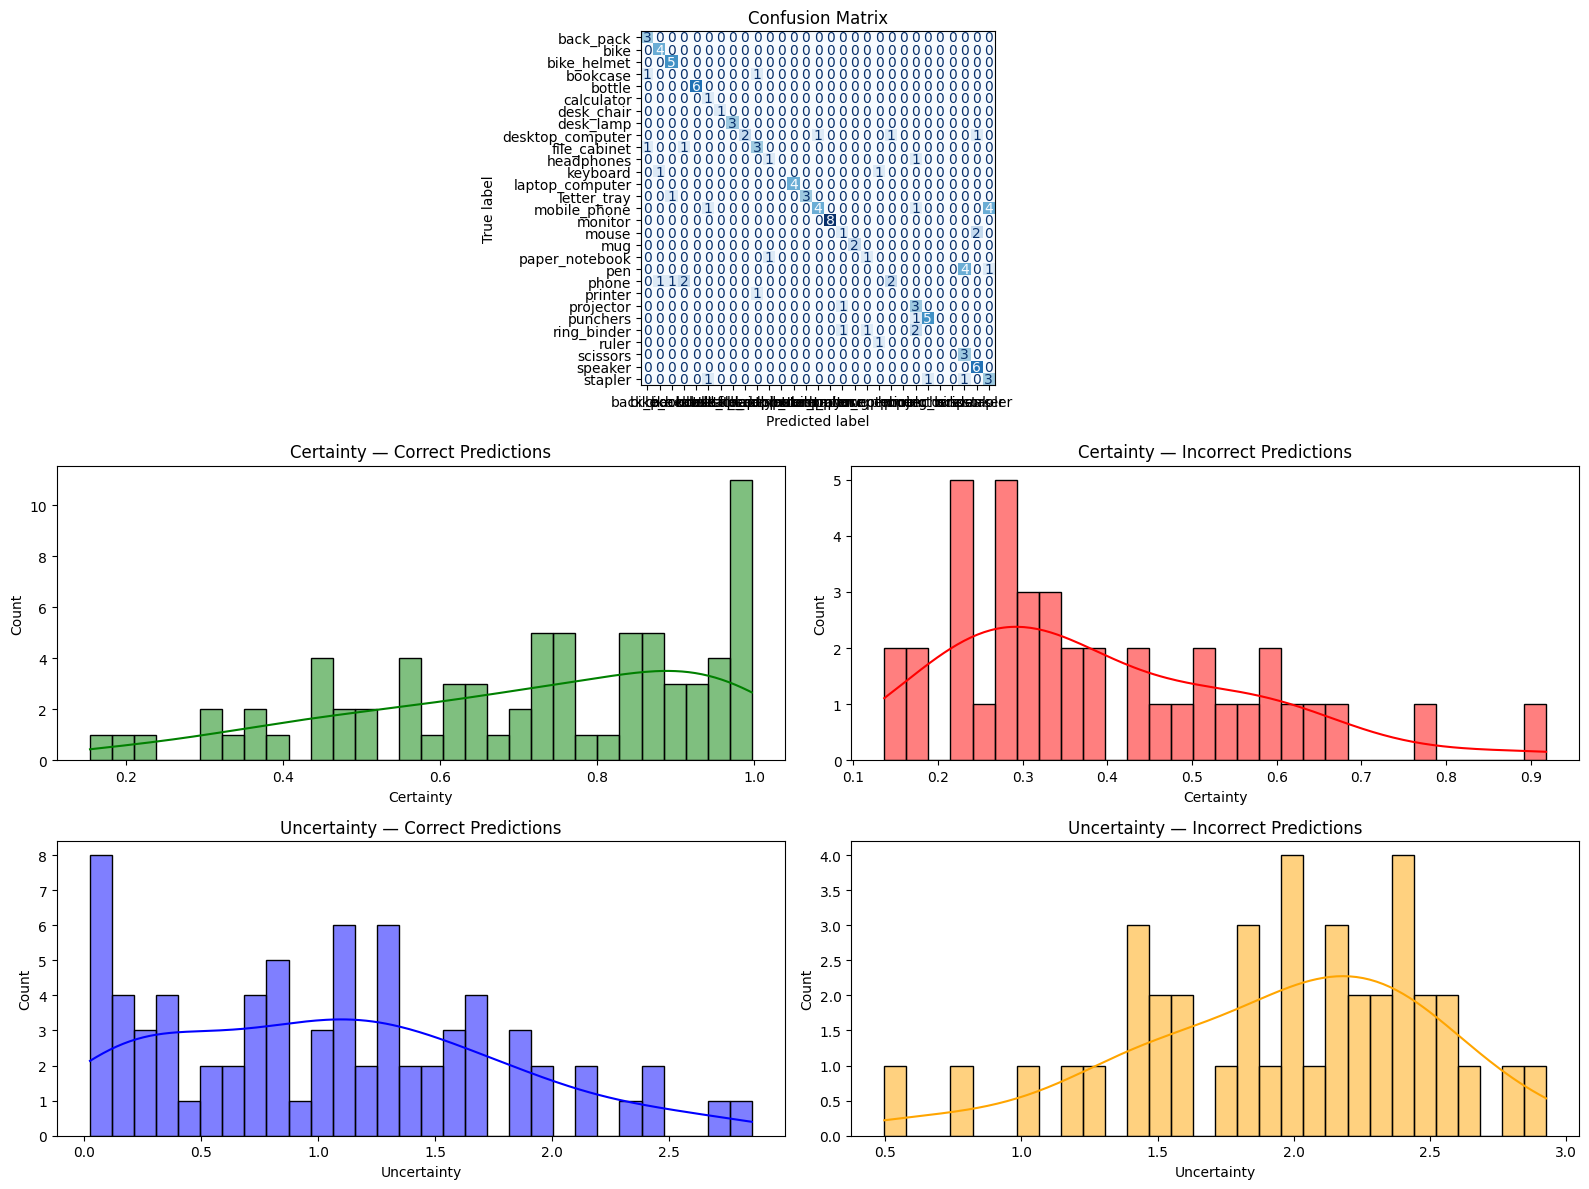

In [38]:
CompleteChecker(domain_model, class_models, cFamiliar_loaders["dslr"], train_domains, train_classes)

# Testing Data Preparation

In [39]:
test_images = []
test_labels = []
unseen_images = []
unseen_labels = []

for d in range(len(eval_domains)):
    domain = eval_domains[d]
    for c in range(len(train_classes)):
        clas = train_classes[c]
        directory_path = os.path.join(data_path, domain, clas)
        for file_name in os.listdir(directory_path):
            file_path = os.path.join(directory_path, file_name)
            test_images.append(image_reader(file_path))
            test_labels.append(c)
    for c in range(len(eval_classes)):
        clas = eval_classes[c]
        directory_path = os.path.join(data_path, domain, clas)
        for file_name in os.listdir(directory_path):
            file_path = os.path.join(directory_path, file_name)
            unseen_images.append(image_reader(file_path))
            unseen_labels.append(c)

In [40]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)
unseen_images = np.array(unseen_images)
unseen_labels = np.array(unseen_labels)

# Create custom datasets and Dataloaders
test_dataset = CustomDataset(test_images, test_labels, transform=test_transform)
unseen_dataset = CustomDataset(unseen_images, unseen_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
unseen_loader  = DataLoader(unseen_dataset, batch_size=32, shuffle=False)

# Model Testing

classification report:
                   precision    recall  f1-score   support

       back_pack       0.55      0.72      0.63        29
            bike       0.48      0.52      0.50        21
     bike_helmet       0.23      0.43      0.30        28
        bookcase       0.10      0.08      0.09        12
          bottle       0.00      0.00      0.00        16
      calculator       0.56      0.16      0.25        31
      desk_chair       0.58      0.28      0.37        40
       desk_lamp       0.05      0.28      0.08        18
desktop_computer       0.11      0.19      0.14        21
    file_cabinet       0.11      0.05      0.07        19
      headphones       0.06      0.07      0.06        27
        keyboard       0.33      0.04      0.07        27
 laptop_computer       0.00      0.00      0.00        30
     letter_tray       0.06      0.11      0.07        19
    mobile_phone       0.00      0.00      0.00        30
         monitor       0.50      0.05      0.09

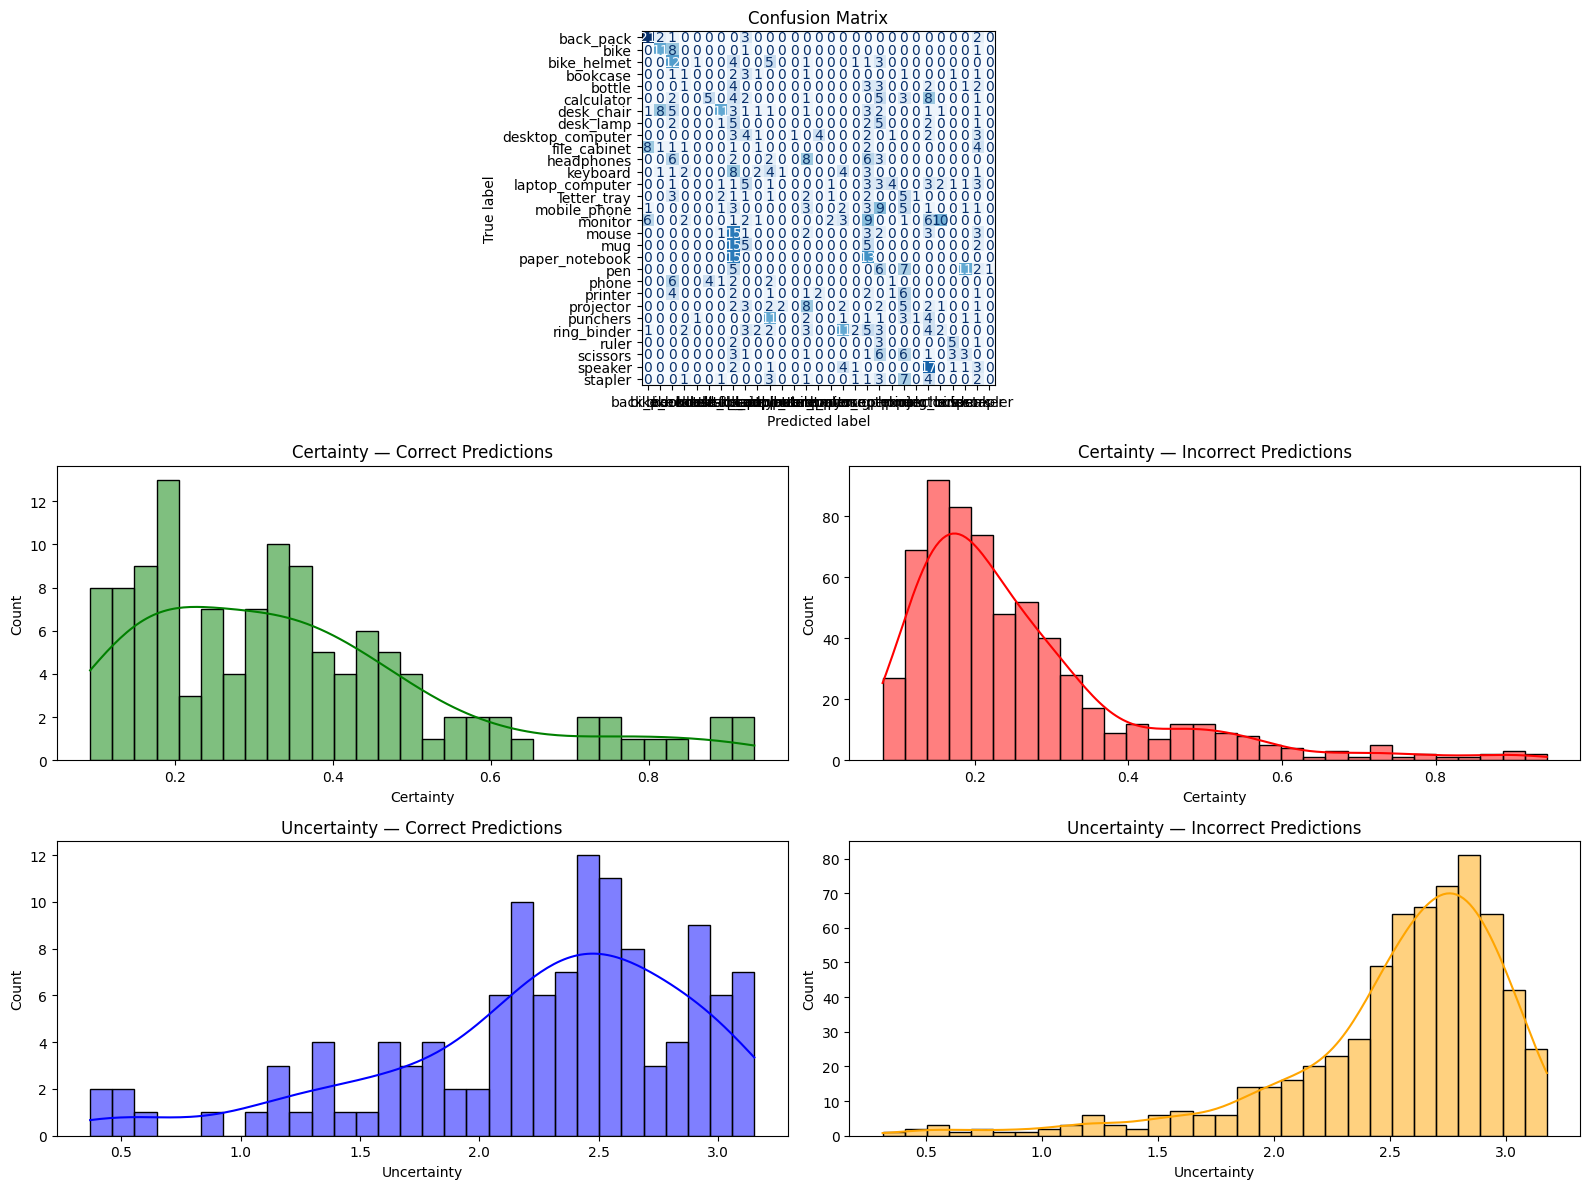

In [41]:
CompleteChecker(domain_model, class_models, test_loader, train_domains, train_classes)

# Unseen Testing

In [42]:
def UnseenChecker(domain_model, class_models, test_loader, train_domain_names):
    domain_model.eval()
    for dom in train_domain_names:
        class_models[dom].eval()

    all_preds=[]
    all_certs=[]
    all_uncerts=[]

    with torch.no_grad():
        for images,_ in test_loader:
            images=images.to(device)

            dom_outputs= domain_model(images)
            dom_probs = F.softmax(dom_outputs, dim=1)

            class_outputs = {}
            class_probs = {}
            for dom in train_domain_names:
                class_outputs[dom] = class_models[dom](images)
                class_probs[dom] = F.softmax(class_outputs[dom], dim=1)
            
            probs = torch.zeros_like(next(iter(class_probs.values())))
            for idx, dom in enumerate(train_domain_names):
                weight = dom_probs[:, idx].unsqueeze(1)
                probs += weight * class_probs[dom]

            certs,preds = torch.max(probs,1)
            uncerts = entropy(probs)

            all_certs.extend(certs.cpu().numpy())
            all_uncerts.extend(uncerts.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_preds=np.array(all_preds)
    all_certs=np.array(all_certs)
    all_uncerts=np.array(all_uncerts)

    # -------------------------------
    # Set up the figure
    # -------------------------------
    fig = plt.figure(figsize=(16, 12))
    grid = GridSpec(3, 2, height_ratios=[1.2, 1, 1])


    ax1 = fig.add_subplot(grid[1, 0])
    sns.histplot(all_certs, bins=30, kde=True, color='green', ax=ax1)
    ax1.set_title('Certainty')
    ax1.set_xlabel('Certainty')
    ax1.set_ylabel('Count')

    ax3 = fig.add_subplot(grid[2, 0])
    sns.histplot(all_uncerts, bins=30, kde=True, color='blue', ax=ax3)
    ax3.set_title('Uncertainty')
    ax3.set_xlabel('Uncertainty')
    ax3.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

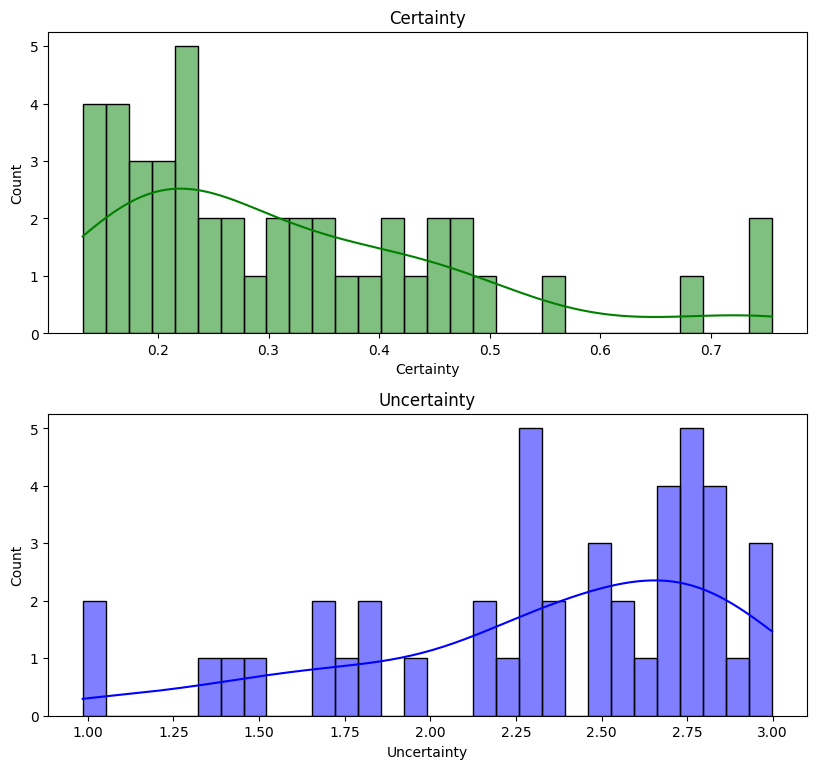

In [43]:
UnseenChecker(domain_model, class_models, unseen_loader, train_domains)

# extras

In [ ]:
# image_paths = []
# image_labels = []
# for d in range(len(eval_domains)):
#     domain = eval_domains[d]
#     for c in range(len(train_classes)):
#         clas = train_classes[c]
#         directory_path = os.path.join(data_path, domain, clas)
#         for file_name in os.listdir(directory_path):
#             file_path = os.path.join(directory_path, file_name)
#             image_paths.append(file_path)
#             image_labels.append(c)

In [ ]:
# pred_path = "../datasets/office31/webcam/bike/frame_0001.jpg"

In [ ]:
# # Move model and image tensor to the device (GPU if available)
# def CompleteEvaluator(img_paths, labels, domain_model=domain_model, class_models=class_models, domain_labels=train_domains, class_labels=train_classes):
#     domain_model.to(device)
#     domain_model.eval()
    

#     for dom in domain_labels:
#         class_models[dom].to(device)
#         class_models[dom].eval()

#     for i in range(len(img_paths)):
#         img = Image.open(img_paths[i]).convert("RGB")

#         transform = transforms.Compose([
#             transforms.Resize((128, 128)),  # Resize to 128x128
#             transforms.ToTensor(),          
#         ])

#         img_tensor = transform(img).unsqueeze(0)
#         img_tensor = img_tensor.to(device)

#         # Evaluate the model on the image
#         with torch.no_grad():
#             preds = []
#             certs = []
#             uncerts = []
#             #AttributeError: 'CustomDataset' object has no attribute 'size'
#             dom_output = domain_model(img_tensor)
#             dom_probs = F.softmax(dom_output, dim=1)
#             j = 0
#             dom = domain_labels[j]
#             class_output = class_models[dom](img_tensor)
#             class_probs = F.softmax(class_output, dim=1)
#             actual_probs = dom_probs[0][j] * class_probs
#             for j in range(1, len(dom_probs[0])):
#                 dom = domain_labels[j]
#                 class_output = class_models[dom](img_tensor)
#                 class_probs = F.softmax(class_output, dim=1)
#                 actual_probs += dom_probs[0][j] * class_probs
#             uncert = entropy(actual_probs)
#             cert, pred = torch.max(actual_probs, dim=1)
#             uncerts.append(uncert)
#             certs.append(cert)
#             preds.append(pred)

#     preds = torch.cat(preds, dim=0).cpu().numpy()
#     certs = torch.cat(certs, dim=0).cpu().numpy()
#     uncerts = torch.tensor(uncerts).cpu().numpy()

#     correct_mask = preds == labels
#     incorrect_mask = ~correct_mask

#     # -------------------------------
#     # Set up the figure
#     # -------------------------------
#     fig = plt.figure(figsize=(16, 12))
#     grid = GridSpec(3, 2, height_ratios=[1.2, 1, 1])


#     ax1 = fig.add_subplot(grid[1, 0])
#     sns.histplot(certs[correct_mask], bins=30, kde=True, color='green', ax=ax1)
#     ax1.set_title('Certainty — Correct Predictions')
#     ax1.set_xlabel('Certainty')
#     ax1.set_ylabel('Count')

#     ax2 = fig.add_subplot(grid[1, 1])
#     sns.histplot(certs[incorrect_mask], bins=30, kde=True, color='red', ax=ax2)
#     ax2.set_title('Certainty — Incorrect Predictions')
#     ax2.set_xlabel('Certainty')
#     ax2.set_ylabel('Count')

#     ax3 = fig.add_subplot(grid[2, 0])
#     sns.histplot(uncerts[correct_mask], bins=30, kde=True, color='blue', ax=ax3)
#     ax3.set_title('Uncertainty — Correct Predictions')
#     ax3.set_xlabel('Uncertainty')
#     ax3.set_ylabel('Count')

#     ax4 = fig.add_subplot(grid[2, 1])
#     sns.histplot(uncerts[incorrect_mask], bins=30, kde=True, color='orange', ax=ax4)
#     ax4.set_title('Uncertainty — Incorrect Predictions')
#     ax4.set_xlabel('Uncertainty')
#     ax4.set_ylabel('Count')

#     plt.tight_layout()
#     plt.show()
#     return 

In [ ]:
# CompleteEvaluator(image_paths, image_labels)

In [ ]:
# # Move model and image tensor to the device (GPU if available)
# def Evaluator(model, img_path, labels):
#     img = Image.open(img_path).convert("RGB")

#     transform = transforms.Compose([
#         transforms.Resize((128, 128)),  # Resize to 128x128
#         transforms.ToTensor(),          
#     ])

#     img_tensor = transform(img).unsqueeze(0)
#     model.to(device)
#     img_tensor = img_tensor.to(device)

#     # Evaluate the model on the image
#     model.eval()
#     with torch.no_grad():
#         #AttributeError: 'CustomDataset' object has no attribute 'size'
#         output = model(img_tensor)
#         print(type(output), output)
#         probs = F.softmax(output, dim=1)
#         print(probs)
#         _, predicted = torch.max(output, dim=1)

#     predicted_label = predicted.item()
#     print(predicted_label, labels[predicted_label])
#     return 

In [ ]:
# # Move model and image tensor to the device (GPU if available)
# def CompleteEvaluator(domain_model, class_models, img_tensor, train_domains, train_classes):
#     domain_model.to(device)
#     img_tensor = img_tensor.to(device)

#     # Evaluate the domain model on the image
#     domain_model.eval()
#     with torch.no_grad():
#         #AttributeError: 'CustomDataset' object has no attribute 'size'
#         domain_logits = domain_model(img_tensor)
#         print(type(output), output)
#         _, predicted = torch.max(output, 1)

#     predicted_label = predicted.item()
#     print(predicted_label, labels[predicted_label])

In [ ]:
# Evaluator(domain_model, pred_path, train_domains)

<class 'torch.Tensor'> tensor([[ 1.0424, -1.1186]], device='cuda:0')
tensor([[0.8967, 0.1033]], device='cuda:0')
0 amazon


In [ ]:
# abc = torch.tensor([[ 1.0424, -1.1186]])
# cdef = torch.tensor([[ 1.0424, -1.1186]])
# abc[0][1]*cdef

tensor([[-1.1660,  1.2513]])

In [ ]:
# Evaluator(class_models["amazon"], img_tensor, train_classes)

<class 'torch.Tensor'> tensor([[-1.6326, -2.8096, -1.0975, -2.1476, -0.9902, -3.5406, -5.9390,  0.2154,
         -0.2974, -0.2006, -1.3874, -2.7867, -2.8676, -1.9978, -2.6757, -3.6056,
         -0.0799, -0.5774, -0.4301, -0.5248,  0.1537, -3.4979, -4.4339,  1.0425,
         -0.9316, -1.7128, -0.6711, -0.7449, -2.5976]], device='cuda:0')
tensor([[1.5129e-02, 4.6628e-03, 2.5836e-02, 9.0398e-03, 2.8764e-02, 2.2450e-03,
         2.0398e-04, 9.6029e-02, 5.7506e-02, 6.3351e-02, 1.9333e-02, 4.7711e-03,
         4.4003e-03, 1.0501e-02, 5.3311e-03, 2.1036e-03, 7.1475e-02, 4.3462e-02,
         5.0361e-02, 4.5809e-02, 9.0283e-02, 2.3429e-03, 9.1883e-04, 2.1958e-01,
         3.0498e-02, 1.3965e-02, 3.9574e-02, 3.6757e-02, 5.7643e-03]],
       device='cuda:0')
23 punchers


In [ ]:
# Evaluator(class_models["dslr"], img_tensor, train_classes)

<class 'torch.Tensor'> tensor([[ 0.4455,  5.0423, -3.3687,  0.4425, -5.1732, -2.7109,  4.9851, -2.2462,
         -0.7672,  3.9686, -1.5845, -0.6298, -0.7301, -1.5858, -2.7337, -3.6440,
         -0.3399, -2.1625, -2.1451, -0.9787, -1.1209,  0.2564, -1.6166, -0.8977,
         -2.3688, -3.3043,  0.4179,  1.2234,  0.3381]], device='cuda:0')
tensor([[4.2280e-03, 4.1931e-01, 9.3249e-05, 4.2156e-03, 1.5345e-05, 1.8003e-04,
         3.9597e-01, 2.8652e-04, 1.2575e-03, 1.4328e-01, 5.5527e-04, 1.4426e-03,
         1.3049e-03, 5.5457e-04, 1.7597e-04, 7.0807e-05, 1.9277e-03, 3.1153e-04,
         3.1700e-04, 1.0177e-03, 8.8281e-04, 3.4997e-03, 5.3777e-04, 1.1036e-03,
         2.5347e-04, 9.9458e-05, 4.1128e-03, 9.2040e-03, 3.7976e-03]],
       device='cuda:0')
1 bike


In [ ]:
# import numpy as np

In [ ]:
# dom_logits = [0.0017, 0.1803]
# dom_probs = [0.4555, 0.5445]

# amazon_logits = np.array([-1.6326, -2.8096, -1.0975, -2.1476, -0.9902, -3.5406, -5.9390,  0.2154,
#          -0.2974, -0.2006, -1.3874, -2.7867, -2.8676, -1.9978, -2.6757, -3.6056,
#          -0.0799, -0.5774, -0.4301, -0.5248,  0.1537, -3.4979, -4.4339,  1.0425,
#          -0.9316, -1.7128, -0.6711, -0.7449, -2.5976])
# amazon_probs = np.array([1.5129e-02, 4.6628e-03, 2.5836e-02, 9.0398e-03, 2.8764e-02, 2.2450e-03,
#          2.0398e-04, 9.6029e-02, 5.7506e-02, 6.3351e-02, 1.9333e-02, 4.7711e-03,
#          4.4003e-03, 1.0501e-02, 5.3311e-03, 2.1036e-03, 7.1475e-02, 4.3462e-02,
#          5.0361e-02, 4.5809e-02, 9.0283e-02, 2.3429e-03, 9.1883e-04, 2.1958e-01,
#          3.0498e-02, 1.3965e-02, 3.9574e-02, 3.6757e-02, 5.7643e-03])

# dslr_logits = np.array([ 0.4455,  5.0423, -3.3687,  0.4425, -5.1732, -2.7109,  4.9851, -2.2462,
#          -0.7672,  3.9686, -1.5845, -0.6298, -0.7301, -1.5858, -2.7337, -3.6440,
#          -0.3399, -2.1625, -2.1451, -0.9787, -1.1209,  0.2564, -1.6166, -0.8977,
#          -2.3688, -3.3043,  0.4179,  1.2234,  0.3381])
# dslr_probs = np.array([4.2280e-03, 4.1931e-01, 9.3249e-05, 4.2156e-03, 1.5345e-05, 1.8003e-04,
#          3.9597e-01, 2.8652e-04, 1.2575e-03, 1.4328e-01, 5.5527e-04, 1.4426e-03,
#          1.3049e-03, 5.5457e-04, 1.7597e-04, 7.0807e-05, 1.9277e-03, 3.1153e-04,
#          3.1700e-04, 1.0177e-03, 8.8281e-04, 3.4997e-03, 5.3777e-04, 1.1036e-03,
#          2.5347e-04, 9.9458e-05, 4.1128e-03, 9.2040e-03, 3.7976e-03])

In [ ]:
# np.argmax(dslr_logits)

1

In [ ]:
# np.argmax(0.0017*amazon_logits + 0.1803*dslr_logits)

1

In [ ]:
# 0.4555*amazon_probs + 0.5445*dslr_probs

array([0.00919341, 0.2304382 , 0.01181907, 0.00641302, 0.01311036,
       0.00112062, 0.21569858, 0.04389722, 0.02687869, 0.10687234,
       0.00910853, 0.00295873, 0.00271485, 0.00508517, 0.00252413,
       0.00099674, 0.0336065 , 0.01996657, 0.02311204, 0.02142014,
       0.0416046 , 0.00297278, 0.00071134, 0.1006196 , 0.01402985,
       0.00641521, 0.02026538, 0.02175439, 0.00469343])

In [ ]:
# np.argmax(0.0017*amazon_logits + 0.1803*dslr_logits)

1

In [ ]:
# prob_score = torch.tensor([[0.00919341, 0.2304382 , 0.01181907, 0.00641302, 0.01311036,
#        0.00112062, 0.21569858, 0.04389722, 0.02687869, 0.10687234,
#        0.00910853, 0.00295873, 0.00271485, 0.00508517, 0.00252413,
#        0.00099674, 0.0336065 , 0.01996657, 0.02311204, 0.02142014,
#        0.0416046 , 0.00297278, 0.00071134, 0.1006196 , 0.01402985,
#        0.00641521, 0.02026538, 0.02175439, 0.00469343]])
# uncertainty = entropy(prob_score)
# uncertainty

tensor([2.4869])

In [ ]:
# len(prob_score[0])

29

In [ ]:
# max_uncert = torch.tensor([[1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,
#                             1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,
#                             1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29]])
# entropy(max_uncert)

tensor([3.3673])

In [ ]:
# max_cert = torch.tensor([[0,0,0,0,0,0,0,0,0,0,
#                           0,0,0,0,0,0,0,0,0,0,
#                           0,0,0,0,0,0,0,0,1]])
# entropy(max_cert)

tensor([nan])